
# EP2 de Programacao Paralela e Distribuída - MAC5742



| Nome | N° USP |
|------|------|
| Ariel Serranoni Soares da Silva| 7658024 |
| Thiago Martinoni | 9793401 |


## Resumo

A ideia deste trabalho é continuar os estudos que iniciamos no [EP1](https://github.com/aserranoni/parallel-mandelbrot).
Mais uma vez, implementaremos duas versões de um algorítmo que gera imagens do conjunto de Mandelbrot; a primeira delas utilizando OpenMPI e a segunda com o auxílio de um acelerador (GPU), usando CUDA. Além disso, vamos realizar experimentos e analisar o desempenho de cada programa afim de estudar brevemente o comportamento de cada implementação. Por fim, vamos comparar os resultados obtidos com os programas do EP1, em que implementamos versões com OpenMP e Pthreads do mesmo algorítmo. Os arquivos utilizados para a produção deste estudo encontram-se disponíveis [neste repositório](https://github.com/martinoni/parallel-ep2).

## Implementações em C

Como mencionado acima temos dois programas, cada um responsável por calcular o conjunto de mandelbrot utilizando um método diferente. Assim como fizemos no EP1, vamos mais uma vez comentar alguns detalhes das implementações que realizamos antes de continuarmos: 

Na versão implementada com OpenMPI,  simplificamos nossa ideia do EP1 de percorrer vetores multidimensionais utilizando um único
índice. Mais uma vez, utilizamos uma única variável `i` percorrendo todos os `image_buffer_size` pixels da nossa imagem.
Sabendo o número `image_size` de pixels em cada linha, conseguimos descobrir a linha (`i/image_size`) e coluna 
(`i%image_size`) exatas de um pixel a partir do parâmetro `i`. O que mudamos em relação ao nosso procedimento foi a maneira
que alocamos os pixels que serão calculados por cada processo. Desta vez, ao invés dividirmos os pixels em intervalos e atribuir cada intervalo a um processo, estamos dividindo os pixels de acordo com as classes de equivalência geradas pela
igualdade "mod" `numprocesses`. Isto é, o  $k$-ésimo processo fica responsável pelos pixels correspondentes aos valores de `i`
tais que `i=k` (mod `numprocesses`). Notando que a relação (de equivalência) que descrevemos induz uma partição do conjunto de píxels, garantimos que a imagem será inteiramente calculada e que não haverão processos diferentes trabalhando na mesma região.
É importante que avisemos que, devido à falta de disponibilidade de máquinas com OpenMPI configurado, todos os processos MPI foram abertos no mesmo computador. Por este motivo, não conseguiremos  testar a capacidade real da biblioteca neste projeto, já que a ideia dela é dividir o trabalho do algorítmo em um número $N>1$ de máquinas.

Já na versão CUDA, precisamos organizar blocos retangulares de threads dentro de grids retangulares. 
Devido a este paradigma e levando em conta a natureza do problema de gerar uma imagem representando o conjunto de Mandelbrot, utilizamos quatro parâmetros para a execução do programa: 

- `gridDim.x`;`gridDim.y`: Representam os tamanhos $x_{grid}$ e $y_{grid}$ dos lados das grids.

- `blockDim.x` e `blockDim.y`: Representam os tamanhos $x_{block}$ e $y_{block}$ dos lados dos blocos.

Desta forma, conseguimos determinar as coordenadas (i_x, i_y) dos pixels em que cada thread trabalhará calculando `i_x=x_block.x*blockDim.x + threadIdx.x` e `i_y=blockIdx.y*blockDim.y + threadIdx.y`. Analogamente à versão implementada utilizando OpenMPI, temos uma partição do conjunto dos pixels da imagem final, possibilitando que toda ela seja calculada e não tenhamos threads executando trabalhos repetidos.

Ressaltamos que, durante a realização dos experimentos, determinamos que $x_{block} = y_{block}$ e que $x_{grid} = y_{grid}$. Desta maneira, diminuímos consideravelmente a quantidade de experimentos que precisaríamos rodar, se comparado ao caso em que consideraríamos todas as combinações de valores possíveis para as dimensões do bloco e da grid. Assumindo que o tempo de execução depende principalmente do número total de threads, não perdemos nenhuma informação relevante na nossa amostra. Em resumo, nos nossos experimentos todos os blocos e grids tem formato quadrado. Apesar disso, o programa `mandelbrot_cuda` pode ser executado com quaisquer parâmetros e formatos retangulares de bloco/grid.

#### Medições do tempo de execução

Neste trabalho estamos reutilizando toda a estrutura para medição de tempo feita no EP1. 
Vale ressaltar que, como foi orientado em aula, iremos medir o tempo de execução dos programas desde seu início até seu término, incluindo o tempo de alocação de memória e da escrita do arquivo no disco. 

A razão para isso é que, no caso do MPI, não podemos desprezar o tempo
que cada máquina levará para alocar memória e que as trocas de mensagens entre os processos consomem. Similarmente, na versão CUDA o tempo de alocação de memória na GPU e de troca de informação da CPU (host) com o acelerador (device) deve ser levado em consideração. 
Na versão implementada utilizando OpenMPI, também é importante ressaltar que, em uma aplicação prática da biblioteca, provavelmente mais de um computador ou rede seriam usados simultaneamente, o que faria que o tempo de execução do programa fosse afetado por outros fatores, como o hardware de cada computador e a velocidade de tráfego de dados entre as conexões ligadas a estes computadores. 


## Máquina utilizada
A execução dos programas neste projeto foi feita na máquina `neozil`, da Rede Linux do IME. O computador suporta o CUDA Toolkit 9.1 e está equipado com duas GPUs Nvidia Tesla K20c SM35. Tais informações foram retiradas [deste site](https://linux.ime.usp.br/wiki/doku.php?id=faq:cuda).

## Infra estrutura Python

Para este relatório, utilizamos Jupyter notebooks e Python na versão 3.7.3. Tal escolha se deve à nossa maior familiaridade com
a linguagem e também à quantidade de material de apoio disponível online. Apesar disso, aproveitamos muitas das ideias dos últimos trabalhos para implementar uma série de funções que foram feitas em Julia anteriormente. A seguinte célula fará as importações necessárias dos pacotes Python:  

In [14]:
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn
from IPython.display import display, HTML
import numpy as np

## Experimentos e Coleta de Dados 

Mais uma vez, para que tenhamos dados para serem analisados, precisamos executar chamadas das nossas implementações em C
e armazenar seus resultados. A seguir, vamos descrever cada argumento da função `mandelbrot()`, que irá nos auxiliar nesta tarefa: 

O primeiro argumento `method` é uma string que determina qual das implementações
em C deve ser chamada. Os valores possíveis para esta variável são `"cuda"`,  `"mpi"`, `"seq"`, `"pth"`, e `"omp"`. 

Os argumentos `c_x_min`, `c_x_max`, `c_y_min`, e `c_y_max` controlam a região do conjunto de mandelbrot que será calculada.

O  argumento `n_mpi` representa o número de processos abertos no programa que utiliza OpenMPI.

O  argumento `x_grid` para a versão em CUDA representa a coordenada x da organização de blocos dentro da grid.

O  argumento `y_grid` para a versão em CUDA representa a coordenada y da organização de blocos dentro da grid.

O  argumento `x_block` para a versão em CUDA representa a coordenada x da organização de threads dentro de cada bloco.

O  argumento `y_block` para a versão em CUDA representa a coordenada y da organização de threads dentro de cada bloco.

O  argumento `n_thread` para as versões em OpenMP e PThreads representam o número de threads utilizadas na execução desses programas

Por fim, o argumento `image_size` controla o tamanho, em pixels, do lado da imagem que será gerada.

Antes de executarmos os programas em C, vamos compilá-los ao executar a seguinte célula:

In [15]:
!make

make: Nothing to be done for 'all'.


In [16]:
# Mandelbrot
def mandelbrot(method, c_x_min, c_x_max, c_y_min, c_y_max, image_size, 
               n_mpi='', x_grid='', y_grid='', x_block='', y_block='', n_thread=''):
    if method == 'ompi':
        program = 'mpirun'
        command = '--quiet --host localhost:%d mandelbrot_ompi %d %d %d %d %d' % (n_mpi, c_x_min, c_x_max, c_y_min, c_y_max, 
                                                                                  image_size)
    else:
        program = './mandelbrot_' + method
        command = " ".join([str(c_x_min), str(c_x_max), str(c_y_min), str(c_y_max), str(image_size), 
                          str(x_grid), str(y_grid), str(x_block), str(y_block), str(n_thread)])
    
    output = !{program} {command}  
    output = output[0].split(', ')
    infos = {'method': method, 
             'duration_clock': output[0],
             'duration_mono': output[1],
             'duration_sys': output[2],
             'n_mpi':n_mpi, 
             'x_grid_cuda':x_grid, 'y_grid_cuda': y_grid, 
             'x_block_cuda': x_block, 'y_block_cuda':y_block,
             'n_threads':n_thread,
            'interaction': None}
    return infos


A função `run_experiments()`, que estamos utilizando desde o miniEP3, é a nossa principal fonte de dados. Ela nos permite variar todos os parâmetros das chamadas feitas pela função `mandelbrot()` e estabelecer um número de repetições através do através do argumento `repetitions`.
Além disso, resultados são coletados e retornados na forma de um `DataFrame`. A função também recebe outros argumentos, que devem estar em forma de lista, e irão indicar quais parâmetros serão usados em cada uma das execuções dos programas em C.


In [17]:
def run_experiments(methods, c_x_min, c_x_max, c_y_min, c_y_max, image_size, 
                    n_mpis=None, grids=None, blocks=None, n_threads = None, repetitions=15):
    results = []
    for method in methods:
        print('Running mandelbrot_' + method) 
        if method == 'ompi':
            for n_mpi in tqdm(n_mpis):
                print('n_processes: %d' %  (n_mpi))
                for i in tqdm(range(repetitions)):
                    result = mandelbrot(method, c_x_min, c_x_max, c_y_min, c_y_max, image_size,
                                       n_mpi)
                    result['interaction'] = i+1
                    results.append(result)
        elif method == 'cuda':
            for grid in grids:
                for block in blocks:
                    if grid != (1,1) or block != (1,1):
                        print('Grid_dim: (%d, %d) and Block_dim: (%d, %d)' %  (grid[0], grid[1], block[0], block[1]))
                        for i in tqdm(range(repetitions)):
                            result = mandelbrot(method, c_x_min, c_x_max, c_y_min, c_y_max, image_size,
                                               x_grid=grid[0], y_grid=grid[1],
                                               x_block=block[0], y_block=block[1])
                            result['interaction'] = i+1
                            results.append(result)
        elif method == 'seq':
            for i in tqdm(range(repetitions)):
                result = mandelbrot(method, c_x_min, c_x_max, c_y_min, c_y_max, image_size)
                result['interaction'] = i+1
                results.append(result)
        elif method == 'pth' or method == 'omp':
            for n_thread in n_threads:
                print('n_threads: %d' %  (n_thread))
                for i in tqdm(range(repetitions)):
                    result = mandelbrot(method, c_x_min, c_x_max, c_y_min, c_y_max, image_size,
                                        n_thread=n_thread)
                    result['interaction'] = i+1
                    results.append(result)

    return results
    

Antes de iniciar os experimentos, vamos ajustar parâmetros da função `run_experiments()` conforme a tabela abaixo.
É importante alertar que a execução dos experimentos pode demorar mais de três horas. Por este motivo, optamos por deixar a linha responsável por esta tarefa comentada.


|   	              | OpenMPI             | CUDA              	            | Sequencial           | Pthreads & OpenMp  | 
|---------------------|---------------------|-----------------------------------|----------------------|--------------------|
| Região                 | Triple Spiral Valley| Triple Spiral Valley           | Triple Spiral Valley |Triple Spiral Valley|
| Tamanho de Imagem      | 4096                | 4096                           | 4096                 | 4096               |
| N° de processos/Threads| $2^1\ldots 2^7$     | None              	            | -                    | $2^1\ldots 2^7$    |
| Dimensões dos blocos| - 	                | $(x_1, x_1)$ para $x_1$ em $2^0\ldots 2^{5}$| -                    | -                  |
| Dimensões do grid   | -                	| $(x_2, x_2)$ para $x_2$ em $2^0\ldots 2^{7}$| -                    | -                  |
| Número de Interações| 15                  | 15                                | 15                   | 15                 |


É importante lembrar que, na implementação em CUDA, apesar de estarmos utilizando organizações quadradas de threads dentro dos blocos e de blocos dentro do grid, qualquer formato formato de bloco ou de grid é possível. Também ressaltamos que para cada família de arquiteturas da Nvidia existe um número máximo de threads por bloco, que no caso da Tesla é 1024. Por isso optamos por um máximo número de $32\times32$ threads por bloco.


In [20]:
# Definição de parâmetros
image_size = (4096)
c_x_min = (-0.188)
c_x_max = (-0.012)
c_y_min = (0.554)
c_y_max = (0.754)

# Definição de parâmetros específicos
methods = ['omp', 'ompi', 'pth', 'cuda', 'seq']
    #OpenMPI
n_mpis = [2**x for x in range(8)]
    #CUDA
grids = [(2**x, 2**x) for x in range(8)]
blocks = [(2**x, 2**x) for x in range(6)]
    #OpenMP e PThreads
n_threads = [2**x for x in range(1, 8)]

# brute = run_experiments(methods, c_x_min, c_x_max, c_y_min, c_y_max, image_size,
#                         n_mpis, grids, blocks, n_threads)
# data_bruto = pd.DataFrame(brute)
# data_bruto.to_csv('testes_brutos.csv', index=False)

In [21]:
data = pd.read_csv('testes_brutos.csv')

Com os parâmetros acima, a função `run_experiments()` realiza 1050 chamadas na linha de comando, gerando um `DataFrame` com
o mesmo número de linhas. A função a seguir irá nos ajudar fazendo uma primeira filtragem nos dados e computando algumas estatísticas que serão importantes na análise a seguir.

In [22]:
def describe_results(data):
    results_mpi = data.groupby(['n_mpi'], as_index=False).agg(
                      {'duration_clock':['mean','std'],'duration_mono':['mean','std'], 
                       'duration_sys':['mean','std']})
    results_cuda = data.groupby(['x_grid_cuda', 'y_grid_cuda', 'x_block_cuda', 'y_block_cuda'], as_index=False).agg(
                      {'duration_clock':['mean','std'],'duration_mono':['mean','std'], 
                       'duration_sys':['mean','std']})
    results_omp = data[data['method'] == 'omp'].groupby(['n_threads'], as_index=False).agg(
                      {'duration_clock':['mean','std'],'duration_mono':['mean','std'], 
                       'duration_sys':['mean','std']})
    results_pth = data[data['method'] == 'pth'].groupby(['n_threads'], as_index=False).agg(
                      {'duration_clock':['mean','std'],'duration_mono':['mean','std'], 
                       'duration_sys':['mean','std']})
    results_seq = data[data['method'] == 'seq'].groupby(['method'], as_index=False).agg(
                      {'duration_clock':['mean','std'],'duration_mono':['mean','std'], 
                       'duration_sys':['mean','std']})
    return {
        'mpi': results_mpi,
        'cuda': results_cuda,
        'omp': results_omp,
        'pth':results_pth,
        'seq':results_seq
    }

Vamos finalmente executar a função acima passando nossos resultados como argumento e salvar em DataFrames separados as informações sobre cada um dos métodos utilizados no nosso experimento:

In [23]:
resumo_experimentos = describe_results(data)
resumo_mpi = resumo_experimentos['mpi']
resumo_cuda = resumo_experimentos['cuda'] 
resumo_omp = resumo_experimentos['omp'] 
resumo_pth = resumo_experimentos['pth'] 
resumo_seq = resumo_experimentos['seq'] 

## Vizualização e Análise dos Resultados



### Analisando resultados individualmente

#### Análise do programa utilizando MPI
Vamos iniciar nossa discussão sobre os resultados do experimento analisando o comportamento da versão MPI. Olharemos primeiramente para o comportamento do tempo médio de execução conforme variamos do número de processos utilizados.

É importante destacar que novamente decidimos utilizar a medição feita pela função em C `clock_gettime()` como padrão em toda a análise feita a seguir.

Text(0.5, 1.0, 'Tempo médio de execução por número de processos - OpenMPI')

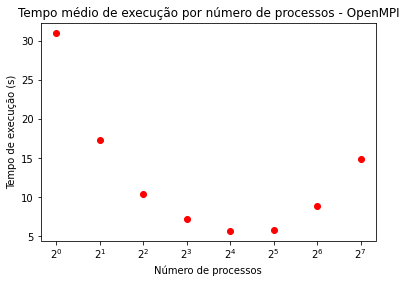

In [11]:
fig, ax = plt.subplots()
plt.errorbar(resumo_mpi['n_mpi'], resumo_mpi['duration_mono']['mean'],fmt='ro')
ax.set_xlabel('Número de processos')
ax.set_ylabel('Tempo de execução (s)')
ax.set_xscale('log', basex=2)
plt.title('Tempo médio de execução por número de processos - OpenMPI')

A partir do gráfico acima pode-se observar que, de maneira geral, dividir a execução de um programa utilizando MPI ajuda a diminuir o tempo de execução do mesmo. Entretanto, também vale notar que, a partir de um certo número de processos, o tempo de execução volta a aumentar, provavelmente pelo tempo necessário para abrir muitos processos. No gráfico a seguir, vamos filtrar
os números de processos que apresentaram menores tempos médios (de $4$ até $64$) e analisar os intervalos de confiança destes casos afim de escolher um número 'ótimo' de processos.

Text(0.5, 1.0, 'Tempo médio por número de processos com intervalos de confiança - OpenMPI')

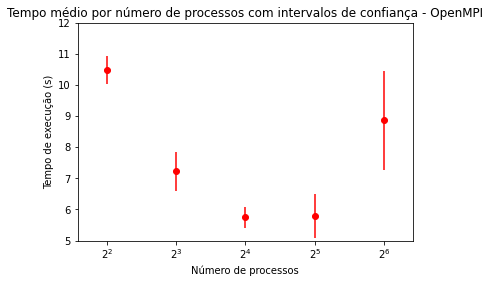

In [93]:
fig, ax = plt.subplots()
plt.xlim([3, 85])
plt.ylim([5, 12])
plt.errorbar(resumo_mpi['n_mpi'], resumo_mpi['duration_mono']['mean'],
             yerr = 2*resumo_mpi['duration_mono']['std'], fmt='ro')
ax.set_xlabel('Número de processos')
ax.set_ylabel('Tempo de execução (s)')
ax.set_xscale('log', basex=2)
plt.title('Tempo médio por número de processos com intervalos de confiança - OpenMPI')

A partir desta última vizualização, decidimos adotar $16$ como o número ótimo de processos para dividirmos nosso programa. Para
embasar nossa escolha, temos dois motivos: o primeiro deles é que a média de tempo de execução é a mais baixa de todos para esse número de processos. Além disso, se comparado a outros candidatos com baixo tempo de execução ($8$ e $32$), o intervalo de confiança mostra-se o menor dentre os três, o que é uma vantagem, porque esperamos que futuros experimentos tenham o máximo de "consistência" possível quanto ao tempo de execução.


#### Análise do programa utilizando CUDA
Para a versão CUDA, faremos um gráfico tridimensional, onde os eixos representam:
- Eixo $x$: Logarítmo na base $2$ da raíz quadrada do número de threads executadas por bloco.
- Eixo $y$: Logarítmos na base $2$ da raíz quadrada do número de blocos executados por grid.
- Eixo $z$: Tempo médio de execução médio, em segundos

Essas transformações foram feitas pelos seguintes motivo:
 - Como os formatos dos blocos e da grid testados são sempre quadrados, então um bloco testado composto por $n$ threads tem dimensões $(\sqrt{n}, \sqrt{n})$, e por isso só precisamos plotar utilizando, para o eixo da dimensão dos blocos, um dos fatores $\sqrt{n}$. O mesmo serve para todas as grids quadradas testadas.
 - O logarítmo foi aplicado para auxiliar na visualização do gráfico, já que, como pode ser constatado [neste link](https://matplotlib.org/3.1.1/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html#mpl_toolkits.mplot3d.axes3d.Axes3D.set_xscale), a biblioteca matplotlib não suporta mudança na escala dos eixos para gráficos tridimensionais.
 
Neste ponto é importante notar que, por mais que tenhamos aplicado transformações não-triviais nas varáveis mencionadas, por se tratarem de funções estritamente crescentes em $\mathbb{R}_{++}$, não alteramos a ordem dos pontos da amostra em relação ao tempo de execução.

Text(0.5, 0.92, 'Variação do tempo médio de execução números de blocos e grids')

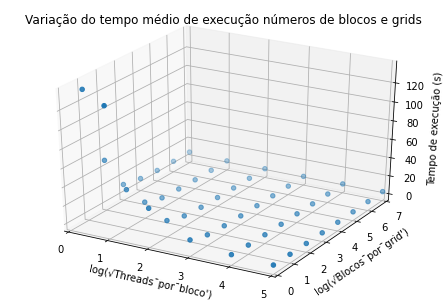

In [13]:
fig = plt.figure()

x = np.log2(resumo_cuda['x_block_cuda'])
y = np.log2(resumo_cuda['x_grid_cuda'])
z = resumo_cuda['duration_mono']['mean']

ax = Axes3D(fig)

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlim(0, 5)
ax.set_ylim(0, 7)

ax.set_xlabel('log(√Threads¯por¯bloco\')')
ax.set_ylabel('log(√Blocos¯por¯grid\')')
ax.set_zlabel('Tempo de execução (s)')
ax.scatter(x, y, zs=z, label='points in (x,z)')

plt.title("Variação do tempo médio de execução números de blocos e grids - CUDA")

O gráfico acima mostra que, de maneira geral, um aumento em qualquer uma das variáveis representadas nos eixos $x$ e $y$ contribui para uma diminuição no tempo médio de execução do programa.

Na nossa próxima vizualização vamos começar a estudar as seções do gráfico acima. Primeiro, olharemos para a mudança no 
tempo médio de execução de acordo com os valores do eixo $x$ do gráfico acima. Além disso, vamos atribuir cores a cada observação de acordo com seus valores no eixo $y$.

Em seguida faremos o processo inverso, olhando a mudança no tempo médio de execução de acordo com os valores do eixo $y$, e atribuindo cores a cada observação de acordo com seus valores no eixo $x$:


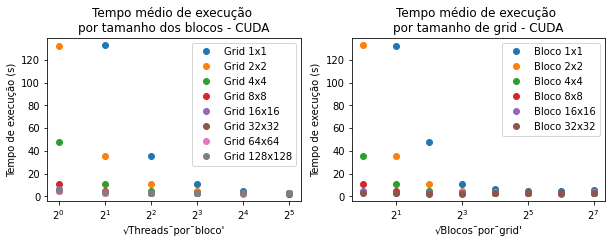

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ax[0].set_xscale('log', basex=2)
for key, group in resumo_cuda.groupby('x_grid_cuda'):
    ax[0].errorbar(group['y_block_cuda'], group['duration_mono']['mean'], 
            label=key, fmt='o')   # 2

legends = ['Grid '+x+'x'+x for x in resumo_cuda['x_grid_cuda'].unique().astype(np.int).astype(np.str)]
ax[0].legend(legends)

ax[0].set_xlabel('√Threads¯por¯bloco\'')
ax[0].set_ylabel('Tempo de execução (s)')
ax[0].set_title('Tempo médio de execução \npor tamanho dos blocos - CUDA')

ax[1].set_xscale('log', basex=2)
for key, group in resumo_cuda.groupby('x_block_cuda'):
    ax[1].errorbar(group['y_grid_cuda'], group['duration_mono']['mean'], 
            label=key, fmt='o')   # 2

legends = resumo_cuda['x_block_cuda'].unique()
legends.sort()
legends = ['Bloco '+x+'x'+x for x in legends.astype(np.int).astype(np.str)]
ax[1].legend(legends)

ax[1].set_xlabel('√Blocos¯por¯grid\'')
ax[1].set_ylabel('Tempo de execução (s)')
ax[1].set_title('Tempo médio de execução \npor tamanho de grid - CUDA')

plt.show()

Como podemos ver, os gráficos acima confirmam nossa primeira impressão obtida através do gráfico tridimensional. Por exemplo, para grids $1\times1$, podemos notar a diminuição do tempo de execução com o aumento do tamanho dos blocos, sendo que o mesmo vale no segundo gráfico, para os blocos $1\times1$ com o aumento do tamanho das grids. 
    
Existem muitos possíveis candidatos a parâmetros ótimos, já que há uma grande quantidade de pontos que correspondem a baixos tempos de execução. Para sistematizar nossa escolha, iremos escolher primeiramente tamanhos de grid correspondentes a baixos tempos de execução. Feito isso, vamos selecionar o tamanho de bloco que apresentar melhor desempenho para o tamanho escolhido para o grid. 

Sendo assim, olhando apenas para o primeiro gráfico, escolhemos continuar analisando o conjunto de grids $16\times16$, $32\times32$, $64\times64$ e $128\times128$. Portanto, a seguir repetiremos o gráfico citado somente com os experimentos correspondentes a estes tamanhos de grid:

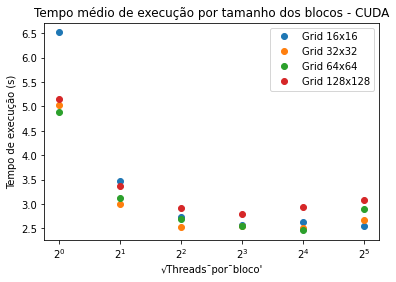

In [89]:
fig, ax = plt.subplots()
ax.set_xscale('log', basex=2)
for key, group in resumo_cuda.loc[23:].groupby('x_grid_cuda'):
    plt.errorbar(group['y_block_cuda'], group['duration_mono']['mean'], 
            label=key, fmt='o')   # 2
    
legends = ['Grid '+x+'x'+x for x in resumo_cuda[23:]['x_grid_cuda'].unique().astype(np.int).astype(np.str)]
plt.legend(legends)

ax.set_xlabel('√Threads¯por¯bloco\'')
ax.set_ylabel('Tempo de execução (s)')
plt.title('Tempo médio de execução por tamanho dos blocos - CUDA')

plt.show()

Podemos ver que, com exeção das amostras ligadas a tamanhos de bloco $1\times1$ e $2\times2$, praticamente todas as observações com Grids $128\times128$ tiveram desempenho inferior se comparadas às restantes, apesar de conterem mais blocos em sua composição. É por isso que eliminaremos esta do conjunto de possíveis escolhas.

A seguir, excluiremos o conjunto de amostras com grids $128\times128$ e observaremos, além da média, como se comportam os intervalos de confiança para os outros valores:

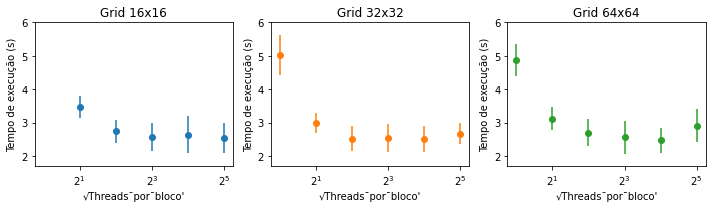

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
ax[0].set_xscale('log', basex=2)
ax[1].set_xscale('log', basex=2)
ax[2].set_xscale('log', basex=2)

ax[0].set_ylim(1.7, 6)
ax[1].set_ylim(1.7, 6)
ax[2].set_ylim(1.7, 6)

cuda_1 = resumo_cuda[resumo_cuda.x_grid_cuda == 16]
cuda_2 = resumo_cuda[resumo_cuda.x_grid_cuda == 32]
cuda_3 = resumo_cuda[resumo_cuda.x_grid_cuda == 64]

ax[0].errorbar(cuda_1['x_block_cuda'], cuda_1['duration_mono']['mean'],
             yerr = 2*cuda_1['duration_mono']['std'], fmt='o', color='tab:blue')
ax[1].errorbar(cuda_2['x_block_cuda'], cuda_2['duration_mono']['mean'],
             yerr = 2*cuda_2['duration_mono']['std'], fmt='o', color='tab:orange')
ax[2].errorbar(cuda_3['x_block_cuda'], cuda_3['duration_mono']['mean'],
             yerr = 2*cuda_3['duration_mono']['std'], fmt='o', color='tab:green')

ax[0].set_xlabel('√Threads¯por¯bloco\'')
ax[0].set_ylabel('Tempo de execução (s)')
ax[0].set_title('Grid 16x16')

ax[1].set_xlabel('√Threads¯por¯bloco\'')
ax[1].set_ylabel('Tempo de execução (s)')
ax[1].set_title('Grid 32x32')

ax[2].set_xlabel('√Threads¯por¯bloco\'')
ax[2].set_ylabel('Tempo de execução (s)')
ax[2].set_title('Grid 64x64')


fig.tight_layout()

Podemos observar que, com exceção da amostra com Grid $16\times16$ e bloco $1\times1$ (que possui um tempo de execução tão alto em relação aos demais que nem aparece no primeiro gráfico), os três gráficos se parecem muito, dificultando uma escolha adequada dentro desse conjunto de três possibilidades de tamanho de grid, além de tantas possíveis escolhas de tamanho de bloco. É por este motivo que vamos construir uma tabela para nos auxiliar nessa escolha:

In [15]:
melhores_cuda = resumo_cuda.loc[23:40].iloc[:, [0,1,2,3,4,5]]
melhores_cuda['x_grid_cuda'] = melhores_cuda['x_grid_cuda'].astype('int')
melhores_cuda['y_grid_cuda'] = melhores_cuda['y_grid_cuda'].astype('int')
melhores_cuda['x_block_cuda'] = melhores_cuda['x_block_cuda'].astype('int')
melhores_cuda['y_block_cuda'] = melhores_cuda['y_block_cuda'].astype('int')

melhores_cuda.columns = ['Grid x', 'Grid y', 'Block x', 'Block y', 'Tempo de execução médio (s)', 'Desvio Padrão (s)']
display(melhores_cuda.style.hide_index())


Grid x,Grid y,Block x,Block y,Tempo de execução médio (s),Desvio Padrão (s)
16,16,1,1,5.822806,0.141245
16,16,2,2,2.814605,0.151941
16,16,4,4,2.095421,0.145164
16,16,8,8,1.884116,0.170660
16,16,16,16,1.955415,0.159179
16,16,32,32,1.856428,0.194157
32,32,1,1,4.304868,0.121721
32,32,2,2,2.381821,0.118815
32,32,4,4,1.882958,0.138598
32,32,8,8,1.857570,0.179346


Podemos ver que há vários candidatos que possuem uma baixa média de tempo de execução, mas existe um destes que, apesar de não ser o com menor amplitude do intervalo de confiança, possui menor tempo médio de execução ($\approx 1,81 s$).

Desta forma, escolhemos como potencial conjunto de parâmetros para executar os experimentos:
- Dimensão da grid:  $(32, 32)$
- Dimensão dos blocos:  $(16, 16)$ 

### Escolha de parâmetros para PThreads e OpenMP

Assim como fizemos acima para as implementações do EP2, vamos escolher parâmetros 'ótimos' para as implementações feitas no EP1, para que possamos comparar as versões de cada programa que obtiveram 'melhor' desempenho.

#### OpenMP

Para a versão implementada utilizando OpenMP, vejamos como o tempo médio de execução e os intervalos de confiança variam de acordo com o número de threads:

Text(0.5, 1.0, 'Tempo médio de execução X número de threads, com intervalos de confiança - OpenMP')

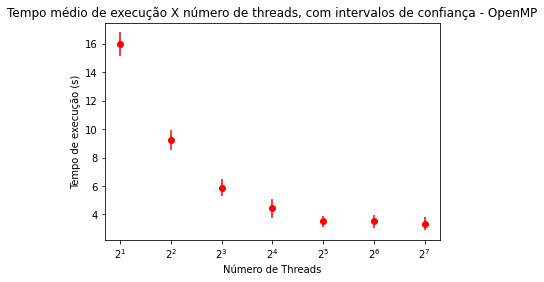

In [9]:
fig, ax = plt.subplots()
plt.errorbar(resumo_omp['n_threads'], resumo_omp['duration_mono']['mean'],
             yerr = 2*resumo_omp['duration_mono']['std'], fmt='ro')
ax.set_xlabel('Número de Threads')
ax.set_ylabel('Tempo de execução (s)')
ax.set_xscale('log', basex=2)
plt.title('Tempo médio de execução X número de threads, com intervalos de confiança - OpenMP')

Podemos ver nitidamente que 32 ($2^5$), 64 ($2^6$) e 128 ($2^7$) foram os números de threads que ofereceram melhor desempenho para a execução do programa, já que tanto o tempo de execução quanto a amplitude do intervalo de confiança destes pontos parecem ser menores se comparados aos de outros. 

Dentre estes três candidatos que citamos, optamos por escolher o número $2^7=128$
pois ele é o que apresenta menor média entre os três. Além disso, observando atentamente a posição do ponto correspondente a este valor em relação à linha que representa o intervalo de confiança, pode-se notar que a média da amosta está abaixo da mediana. Considerando o tamanho reduzido da nossa amostra, podemos pensar nesse fato como um indicador de que tivemos algum 'outlier' em alguma(s) das 15 repetições do programa com $128$ threads. Nesse contexto, podemos imaginar que o intervalo de confiança que obteríamos caso tivéssemos uma amostra maior seria menor.

A seguir, vamos repetir a vizualização acima considerando a implementação em que utilizamos PThreads:

Text(0.5, 1.0, 'Tempo médio de execução por número de threads - PThreads')

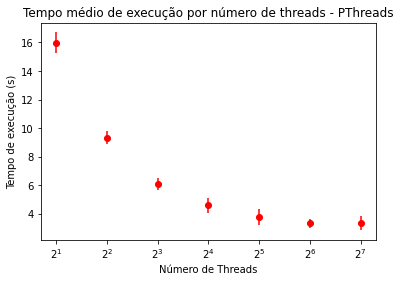

In [18]:
fig, ax = plt.subplots()
plt.errorbar(resumo_pth['n_threads'], resumo_pth['duration_mono']['mean'],
             yerr = 2*resumo_pth['duration_mono']['std'], fmt='ro')
ax.set_xlabel('Número de Threads')
ax.set_ylabel('Tempo de execução (s)')
ax.set_xscale('log', basex=2)
plt.title('Tempo médio de execução por número de threads, com intervalos de confiança - PThreads')

Analogamente ao caso do OpenMP, temos mais de um concorrente a número 'ótimo' de threads, uma vez que os resultados que obtivemos com 64 ($2^6$) e 128 ($2^7$) threads tem menor tempo médio de execução e menor intervalo de confiança quando comparados a todos os outros parâmetros que testamos. Entre estes dois concorrentes, escolhemos o $2^6=64$ como o 'melhor' simplesmente por ter menor intervalo de confiança.

Em resumo, os parâmetros 'ótimos' que determinamos para cada versão são:

- OpenMP: 64 threads
- PThreads: 128 threads

### Comparação de todas as versões

Agora vamos comparar o tempo médio de execução entre os melhores candidatos das implementações que fizemos ao longo dos dois últimos trabalhos, comentando a respeito de como um acelerador (GPU) pode impactar na velocidade de execução de um programa, assim como dos potenciais de cada implementação.

Definimos a seguinte função para encontrar o subconjunto dos dados originais correspondente às versões de cada implementação que determinamos como 'ótimas':

In [85]:
def data_melhores(data, n_threads_omp, n_threads_pth, n_mpi, grid_cuda, block_cuda):
    melhor_seq = data[data.method=='seq']
    melhor_omp = data[data.method=='omp'][data[data.method=='omp'].n_threads==n_threads_omp]
    melhor_pth = data[data.method=='pth'][data[data.method=='pth'].n_threads==n_threads_pth]
    melhor_mpi = data[data.method=='ompi'][data[data.method=='ompi'].n_mpi==n_mpi]
    grid = data[data.method=='cuda'][data[data.method=='cuda'].x_grid_cuda==grid_cuda]
    block = data[data.method=='cuda'][data[data.method=='cuda'].x_block_cuda==block_cuda]
    melhor_cuda = pd.merge(grid, block, how='inner')

    melhores_versoes = pd.concat([melhor_seq, melhor_omp, melhor_pth, melhor_mpi, melhor_cuda], axis=0)
    return melhores_versoes

Executando a função acima com todos os parâmetros escolhidos:

In [88]:
melhores_versoes = data_melhores(data, 64, 128, 16, 32, 16)

E fazendo um boxplot de comparação entre todos os métodos:

[Text(0, 0.5, 'Tempo de duração (s)'),
 Text(0.5, 0, 'Método'),
 Text(0.5, 1.0, 'Boxplot de comparação entre todos os métodos')]

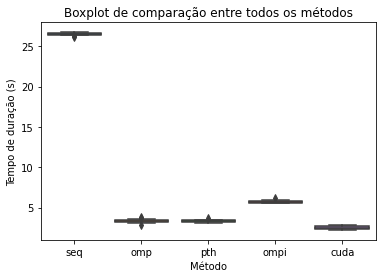

In [87]:
seaborn.boxplot(x=melhores_versoes['method'], y=melhores_versoes['duration_mono'].astype('float')
               ).set(xlabel='Método', ylabel='Tempo de duração (s)',
                    title='Boxplot de comparação entre todos os métodos')

Como podemos ver no gráfico acima, de maneira geral, a paralelização em qualquer tipo de implementação diminui muito o tempo de execução do programa, se comparados com tempo de execução da versão sequencial. Essa discrepância entre as distribuições de tempo da versão sequencial e das demais chega a gerar uma certa deformidade no gráfico de boxplot, uma vez que as versões paralelas chegam a ser cerca de cinco vezes mais rápidas do que a versão sequencial.

Analisando somente as versões paralelizadas:

[Text(0, 0.5, 'Tempo de duração (s)'),
 Text(0.5, 0, 'Método'),
 Text(0.5, 1.0, 'Boxplot de comparação entre métodos de implementação')]

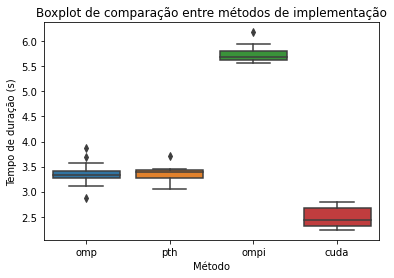

In [28]:
seaborn.boxplot(x=melhores_versoes[melhores_versoes.method!='seq']['method'],
                y=melhores_versoes[melhores_versoes.method!='seq']['duration_mono'].astype('float')
               ).set(xlabel='Método', ylabel='Tempo de duração (s)',
                    title='Boxplot de comparação entre métodos de implementação')

A vizualização acima nos mostra que o desempenho do algorítmo implementado em CUDA, com auxílio de um acelerador, é superior se comparado aos resultados das outras implementações. Este fato é de se esperar pois o acelerador
é um hardware extra cujo objetivo é justamente auxiliar a CPU a realizar tarefas mais rapidamente.

Também podemos pontuar que o desempenho das versões implementadas utilizando OpenMP e PThreads se equiparam, não havendo evidências de uma diferença notável nas distribuições do tempo de execução destas. 

Finalmente, também notamos que a versão implementada em OpenMPI teve o pior desempenho dentre as quatro. Provavelmente este fato pode ser atribuído à infra-estrutura do pacote, que deve preparar cada tarefa para ser enviada para uma outra máquina. Este processo, além de não trazer nenhum ganho no nosso caso, pois estamos usando apenas uma máquina, prejudica o tempo de execução desta implementação em relação aos programas que são próprios para execução em uma única máquina.

## Conclusões e observações finais

### Resultados

Como pôde ser visto ao longo da disciplina, aumentar o número de threads ou processos rodando simultaneamente não significa que o desempenho dos programas vá necessariamente melhorar. O tempo de execução de um programa também depende de outros fatores como o tempo utilizado para criar threads, alocar tarefas, e, no caso distribuído, principalmente do tempo utilizado para que  informações sejam trocadas por diferentes máquinas. Apesar disso, conseguimos montar uma estratégia simples para selecionar e sugerir quais parâmetros podem nos ajudar a minimizar a média e a variabilidade no tempo de execução de um programa. 

####  Potencial dos pacotes

Como comentamos anteriormente, nos experimentos realizados em uma mesma máquina, o desempenho da versão em MPI foi nitidamente inferior ao das demais implementações. Apesar disso, sabemos que o OpenMPI é feito com o intuito de utilizar processamento paralelo em mais de uma máquina, e até em mais de uma rede simultaneamente, coisa que não pudemos incluir nos experimentos devido à falta de disponibilidade de acesso a outras máquinas, seja na mesma rede, seja em outra.

É por este motivo que também sabemos que o desempenho em potencial da versão implementada em OpenMPI é muito maior do que o observado neste projeto, e depende basicamente do número de computadores utilizados simultaneamente, do número de processos abertos em cada computador e também da velocidade de tráfego de informação entre os processos.

Também sabemos que a versão em CUDA pode oferecer um desempenho melhor ainda se utilizarmos GPUs mais poderosas ou modernas, ou até mais de uma GPU simultaneamente, coisa que poderia ser implementada até utilizando CUDA + OpenMPI. Na verdade, visando o desempenho máximo no mundo real, o ideal é que isso fosse feito, já que a máquina neozil da rede Linux oferece duas GPUs localmente. O desempenho seria maior ainda se pudéssemos conectar várias máquinas com uma ou mais GPUs simultaneamnete.

### Infra Estrutura de trabalho remoto utilizando SSH

A realização deste trabalho demandou muito poder computacional. Como nenhum dos elementos da dupla possui uma máquina adequada para realizar os experimentos pedidos, precisamos aprender um pouco sobre o uso remoto da rede IME e da rede Linux. Como
nesse momento em que a grande maioria da comunidade IME não consegue estar fisicamente presente no instituto, resolvemos fazer
uma pequena descrição de como utilizamos a máquina neozil da rede Linux para realizar nossos experimentos.

Em primeiro lugar, gostaríamos de agradecer à comunidade, que 
mantém [esta página](https://wiki.ime.usp.br/) com diversas informações úteis, inclusive 
sobre o acesso remoto às redes do IME. Mais especificamente, 
[esta página](https://wiki.ime.usp.br/servicos:processamento) contém uma lista das máquinas do IME com grande poder computacional e orientações de como utilizá-las. Também gostaríamos de agradecer aos responsáveis pela manutenção [desta página](https://linux.ime.usp.br/wiki/doku.php?id=faq:cuda), que contém mais detalhes sobre a máquina neozil e sua utilização.

#### Abrindo uma porta para acesso local

Mesmo com a interface gráfica de um navegador de internet, ainda temos que lidar com algum tipo de delay, o que torna um tanto desconfortável editar um documento como este. Para resolver este problema, utilizamos os comandos

``` ssh -NL [port]:localhost:[port] [seulogin]@brucutuiv.ime.usp.br```


``` ssh -NL [port]:localhost:[port] [seulogin]@linux.ime.usp.br```

para que possamos acessar o servidor oferecido pelo Jupyter localmente!